# Random Forest Classification

## Imports and base data

In [21]:
import datetime
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree as tr
from imblearn.under_sampling import RandomUnderSampler as UnderSampler
from imblearn.over_sampling import RandomOverSampler as OverSampler
from imblearn.over_sampling import SMOTE
from IPython.display import Image

In [2]:
df = pd.read_csv('data/dbn_for_models.csv')
df.head()

,defects_exist,years_since_last_defects,bldgarea,unitstotal,builtfar,median_household_income,over_65_pct,over_white_pct,dummy_pressure_type,dummy_make,...,landuse_2.0,landuse_3.0,landuse_4.0,landuse_5.0,landuse_6.0,landuse_7.0,landuse_8.0,landuse_9.0,landuse_10.0,landuse_11.0
0,0,0,185785.0,8.0,10.38,135588.0,0.14173,0.783066,1,True,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,185785.0,8.0,10.38,135588.0,0.14173,0.783066,1,True,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2,185785.0,8.0,10.38,135588.0,0.14173,0.783066,1,True,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,3,185785.0,8.0,10.38,135588.0,0.14173,0.783066,1,True,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,4,185785.0,8.0,10.38,135588.0,0.14173,0.783066,1,True,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# normalize some of the fields
cols = ['bldgarea', 'unitstotal', 'builtfar']

for col in cols:
    df[col] = (df[col]-df[col].mean())/df[col].std()
    
df.describe()

,defects_exist,years_since_last_defects,bldgarea,unitstotal,builtfar,median_household_income,over_65_pct,over_white_pct,dummy_pressure_type,defects_history,...,landuse_2.0,landuse_3.0,landuse_4.0,landuse_5.0,landuse_6.0,landuse_7.0,landuse_8.0,landuse_9.0,landuse_10.0,landuse_11.0
count,1.535994e+06,1.535994e+06,1.535994e+06,1.535994e+06,1.535994e+06,1.535994e+06,1.535994e+06,1.535994e+06,1.535994e+06,1.535994e+06,...,1.535994e+06,1.535994e+06,1.535994e+06,1.535994e+06,1.535994e+06,1.535994e+06,1.535994e+06,1.535994e+06,1.535994e+06,1.535994e+06
mean,1.158045e-01,7.038729e+00,8.123164e-18,-1.654239e-17,9.675261e-16,6.983531e+04,1.266336e-01,5.031791e-01,9.965631e-01,1.168581e+00,...,3.511863e-01,1.586966e-01,2.827518e-01,6.232056e-02,1.799226e-02,3.470717e-03,1.035349e-01,1.285161e-03,1.314458e-03,6.145857e-04
std,3.199904e-01,6.136811e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.828123e+04,6.000739e-02,2.831000e-01,5.852395e-02,1.892900e+00,...,4.773412e-01,3.653930e-01,4.503369e-01,2.417369e-01,1.329231e-01,5.881048e-02,3.046564e-01,3.582611e-02,3.623163e-02,2.478323e-02
min,0.000000e+00,0.000000e+00,-3.394371e-01,-2.044870e-01,-1.196623e+00,9.053000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,2.000000e+00,-3.049673e-01,-1.889301e-01,-5.630175e-01,4.195300e+04,8.644256e-02,2.342017e-01,1.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,5.000000e+00,-2.682348e-01,-1.630019e-01,-2.063773e-01,6.029100e+04,1.177924e-01,5.311271e-01,1.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,1.000000e+01,-4.763509e-02,-5.410344e-02,2.792605e-01,8.720400e+04,1.557648e-01,7.664161e-01,1.000000e+00,2.000000e+00,...,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,2.700000e+01,9.465637e+01,4.993548e+01,1.694650e+01,2.500010e+05,8.933031e-01,1.000000e+00,1.000000e+00,1.900000e+01,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [4]:
# separate dependent variable (defects_exist)
X, y = df.iloc[:,1:].values, df.iloc[:,0].values

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 2015)

In [6]:
# Percentage of failures
print(round(float(df.defects_exist.sum())/float(df.defects_exist.count())*100, 1))
print(100 - (round(float(df.defects_exist.sum())/float(df.defects_exist.count())*100, 1)))

11.6
88.4


## Function to run new models and print out useful stats

In [7]:
def run_model(X_train, X_test, y_train, y_test, rfc_params):
    # Timing
    start = datetime.datetime.now()
    print("Start time: {}".format(start))
    
    # Initiate and fit
    if rfc_params != None:
        rfc=RandomForestClassifier(**rfc_params)
    else:
        rfc=RandomForestClassifier(random_state=2015)
    rs=rfc.fit(X_train,y_train)
    
    # Y predictions
    y_pred_train = rs.predict_proba(X_train)[:,1]
    y_pred_test = rs.predict_proba(X_test)[:,1]
    end = datetime.datetime.now()
    print("End time: {}".format(end))
    print('Took {} seconds or {} minutes'.format((end-start).total_seconds(), (end-start).total_seconds()/60))
    print("")

    # measure accuracy for the binary prediction task
    print('In sample prediction accuracy: {}%'.format(round(1.0*sum((y_pred_train>0.5)==y_train)/len(y_train)*100, \
                                                            3)))
    print('Out of sample prediction accuracy: {}%'.format(round(1.0*sum((y_pred_test>0.5)==y_test)/len(y_test)*100, \
                                                                3)))
    print("")
    
    # Confusion matrix and performance metrics
    pred_classes = y_pred_test>0.5
    print("Confusion matrix:")
    print("")
    print(metrics.confusion_matrix(y_test, pred_classes))
    print("")
    print('Recall: {}%'.format(round(metrics.recall_score(y_test, pred_classes)*100, 3)))
    print('Precision: {}%'.format(round(metrics.precision_score(y_test, pred_classes)*100, 3)))
    print('F1 score: {}%'.format(round(metrics.f1_score(y_test, pred_classes)*100, 3)))
    print("")
    
    return rs

## Basic model

In [8]:
basic_params = {'random_state':2015}
run_model(X_train, X_test, y_train, y_test, basic_params)

Start time: 2019-05-09 18:36:10.878381


/nfshome/shb395/.conda/envs/myEnvp3/lib/python2.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


End time: 2019-05-09 18:36:37.800379
Took 26.921998 seconds or 0.448699966667 minutes

In sample prediction accuracy: 97.962%
Out of sample prediction accuracy: 89.102%

Confusion matrix:

[[526702  16640]
 [ 50317  20739]]

Recall: 29.187%
Precision: 55.483%
F1 score: 38.251%



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=2015, verbose=0,
            warm_start=False)

### Model revision

Due to the relatively poor performance of our initial model, we reviewed our data and realized that the imbalanced nature of the data (approx. 88% of data points had no defects while the other 12% had defects) was the likely cause of the poor performance. We therefore decided to utilize various data sampling techniques available through imblearn to balance the training datasets. Balancing techniques and outcomes can be seen in the following cells.

## Under sampling

In [9]:
under_sampler = UnderSampler(random_state=1992)
X_train_und, y_train_und = under_sampler.fit_resample(X_train, y_train)
X_train_und.shape, y_train_und.shape

((213638, 24), (213638,))

In [10]:
rfc_params_und3 = {'n_estimators':100, 'random_state':2015}
run_model(X_train_und, X_test, y_train_und, y_test, rfc_params_und3)

Start time: 2019-05-09 18:36:43.638688
End time: 2019-05-09 18:37:54.410906
Took 70.772218 seconds or 1.17953696667 minutes

In sample prediction accuracy: 99.345%
Out of sample prediction accuracy: 75.565%

Confusion matrix:

[[414931 128411]
 [ 21719  49337]]

Recall: 69.434%
Precision: 27.757%
F1 score: 39.659%



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=2015, verbose=0,
            warm_start=False)

## Over sampling

In [11]:
over_sampler = OverSampler(random_state=2015)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
X_train_over.shape, y_train_over.shape

((1629554, 24), (1629554,))

### Lots of trees

In [12]:
rfc_params_over3 = {'n_estimators':100, 'random_state':2015}
run_model(X_train_over, X_test, y_train_over, y_test, rfc_params_over3)

Start time: 2019-05-09 18:38:01.561320
End time: 2019-05-09 18:45:19.367059
Took 437.805739 seconds or 7.29676231667 minutes

In sample prediction accuracy: 99.319%
Out of sample prediction accuracy: 87.71%

Confusion matrix:

[[511266  32076]
 [ 43436  27620]]

Recall: 38.871%
Precision: 46.268%
F1 score: 42.248%



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=2015, verbose=0,
            warm_start=False)

## SMOTE

In [13]:
sampler = SMOTE(random_state=2015)
X_train_smote, y_train_smote = sampler.fit_resample(X_train, y_train)

In [14]:
rfc_params = {'n_estimators':100,'random_state':2015}
rf_final = run_model(X_train_smote, X_test, y_train_smote, y_test, rfc_params)

Start time: 2019-05-09 18:45:42.112309
End time: 2019-05-09 18:53:30.887095
Took 468.774786 seconds or 7.8129131 minutes

In sample prediction accuracy: 99.538%
Out of sample prediction accuracy: 88.657%

Confusion matrix:

[[519235  24107]
 [ 45582  25474]]

Recall: 35.851%
Precision: 51.379%
F1 score: 42.232%



In [15]:
rf_final

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=2015, verbose=0,
            warm_start=False)

## Finding important features

In [16]:
importances = rf_final.feature_importances_

std = np.std([tree.feature_importances_ for tree in rf_final.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d: %s (%f)" % (f + 1, indices[f], df.columns[f+1], importances[indices[f]]))

Feature ranking:
1. feature 0: years_since_last_defects (0.233340)
2. feature 12: bldgarea (0.177032)
3. feature 11: unitstotal (0.081776)
4. feature 2: builtfar (0.062973)
5. feature 1: median_household_income (0.057920)
6. feature 3: over_65_pct (0.055905)
7. feature 9: over_white_pct (0.047396)
8. feature 8: dummy_pressure_type (0.043365)
9. feature 4: dummy_make (0.040946)
10. feature 5: dummy_model (0.040885)
11. feature 6: dummy_tract (0.040766)
12. feature 16: dummy_owner (0.033561)
13. feature 14: defects_history (0.029057)
14. feature 20: landuse_1.0 (0.018454)
15. feature 15: landuse_2.0 (0.018013)
16. feature 17: landuse_3.0 (0.008668)
17. feature 10: landuse_4.0 (0.004495)
18. feature 13: landuse_5.0 (0.002119)
19. feature 18: landuse_6.0 (0.002076)
20. feature 7: landuse_7.0 (0.000541)
21. feature 19: landuse_8.0 (0.000356)
22. feature 21: landuse_9.0 (0.000161)
23. feature 22: landuse_10.0 (0.000140)
24. feature 23: landuse_11.0 (0.000054)


#### Method 1: Use feature importance module of random forest classifier
Problem: Feature selection based on impurity reduction is biased towards preferring variables with more categories

In [18]:
# From sklearn here: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = rf_final.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_final.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]

# This is what I should've used the previous time
feature_names = df.columns[1:]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d: %s (%f)" % (f + 1, indices[f], df.columns[f+1], importances[indices[f]]))

Feature ranking:
1. feature 0: years_since_last_defects (0.233340)
2. feature 12: bldgarea (0.177032)
3. feature 11: unitstotal (0.081776)
4. feature 2: builtfar (0.062973)
5. feature 1: median_household_income (0.057920)
6. feature 3: over_65_pct (0.055905)
7. feature 9: over_white_pct (0.047396)
8. feature 8: dummy_pressure_type (0.043365)
9. feature 4: dummy_make (0.040946)
10. feature 5: dummy_model (0.040885)
11. feature 6: dummy_tract (0.040766)
12. feature 16: dummy_owner (0.033561)
13. feature 14: defects_history (0.029057)
14. feature 20: landuse_1.0 (0.018454)
15. feature 15: landuse_2.0 (0.018013)
16. feature 17: landuse_3.0 (0.008668)
17. feature 10: landuse_4.0 (0.004495)
18. feature 13: landuse_5.0 (0.002119)
19. feature 18: landuse_6.0 (0.002076)
20. feature 7: landuse_7.0 (0.000541)
21. feature 19: landuse_8.0 (0.000356)
22. feature 21: landuse_9.0 (0.000161)
23. feature 22: landuse_10.0 (0.000140)
24. feature 23: landuse_11.0 (0.000054)


#### Method 2: Use predictions from Random Forest to train a Descision Tree, look at its branching structure

In [19]:
pred_final = rf_final.predict(X_test)

In [22]:
#train decision tree to best predict output from random forest
dt_eval = DecisionTreeClassifier(max_depth = 3, random_state=2015)
dt_eval.fit(X_test, pred_final)

# Get text string for WebGraphViz
rf_string = tr.export_graphviz(dt_eval,  out_file=None, max_depth=3, 
                               feature_names=df.iloc[:,1:].columns.values,
                              class_names=['0','1'],
                         filled=True, rounded=True,  
                         special_characters=False,impurity=True)

In [23]:
# Save string to file
text_file = open("data/rf_wepgraphviz_string.txt", "w")
text_file.write(rf_string)
text_file.close()

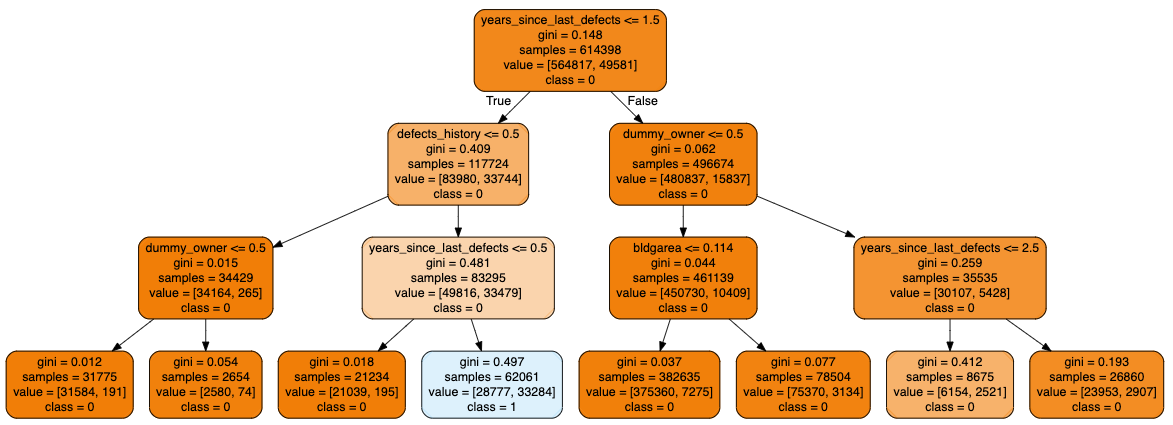

In [24]:
# Taken from WebGraphViz using rf_string
Image('data/rf_smote_feature_dt.png')